In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from joblib import dump, load

In [2]:
data_path = "Handdata/hand_data.csv"
model_path = "model/hand_gesture_model.h5"
scaler_path = "model/hand_scaler.pkl"
model_name = 'hand_gesture_model.h5'
batch_size = 32
num_epochs = 50
lr = 1e-4
test_size = 0.2
random_state = 42
patience = 10 

In [3]:
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}")

data = pd.read_csv(data_path).dropna().reset_index(drop=True)
print(f"Loaded {len(data)} samples from {data_path}")

Loaded 10000 samples from Handdata/hand_data.csv


In [4]:
X = data.drop("ID", axis=1).values.reshape(-1, 21, 3)
for i in range(len(X)):
    wrist = X[i, 0, :].copy()
    X[i] -= wrist

X = X.reshape(len(X), -1)
y = data["ID"].values

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

num_classes = y_categorical.shape[1]
features = X.shape[1]
if os.path.exists(scaler_path):
    print("Loading existing scaler...")
    scaler = load(scaler_path)
else:
    print("Fitting new scaler...")
    scaler = StandardScaler()
    scaler.fit(X)
    dump(scaler, scaler_path)
    print("Scaler saved.")

X_scaled = scaler.transform(X)

Loading existing scaler...


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical,
    test_size=test_size,
    random_state=random_state,
    stratify=y_categorical
)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    f"model/{model_name}",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [7]:
model = Sequential()
model.add(Dense(512, input_dim=features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               32768     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 165381 (646.02 KB)
Trainable params: 165381 (646.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = model.fit(
    X_train, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


250/250 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.6155  
Epoch 1: val_accuracy improved from -inf to 0.81500, saving model to model\hand_gesture_model.h5
250/250 [==============================] - 5s 11ms/step - loss: 1.0481 - accuracy: 0.6155 - val_loss: 0.6246 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 2/50
 14/250 [>.............................] - ETA: 2s - loss: 0.7332 - accuracy: 0.7589

C:\Users\Rohan\.conda\envs\vatawaran\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


249/250 [============================>.] - ETA: 0s - loss: 0.6050 - accuracy: 0.7932
Epoch 2: val_accuracy improved from 0.81500 to 0.88700, saving model to model\hand_gesture_model.h5
250/250 [==============================] - 2s 9ms/step - loss: 0.6041 - accuracy: 0.7935 - val_loss: 0.3970 - val_accuracy: 0.8870 - lr: 1.0000e-04
Epoch 3/50
246/250 [============================>.] - ETA: 0s - loss: 0.4424 - accuracy: 0.8549
Epoch 3: val_accuracy improved from 0.88700 to 0.91800, saving model to model\hand_gesture_model.h5
250/250 [==============================] - 2s 8ms/step - loss: 0.4434 - accuracy: 0.8547 - val_loss: 0.2970 - val_accuracy: 0.9180 - lr: 1.0000e-04
Epoch 4/50
248/250 [============================>.] - ETA: 0s - loss: 0.3487 - accuracy: 0.8897
Epoch 4: val_accuracy improved from 0.91800 to 0.93700, saving model to model\hand_gesture_model.h5
250/250 [==============================] - 2s 7ms/step - loss: 0.3477 - accuracy: 0.8901 - val_loss: 0.2333 - val_accuracy: 0.9

63/63 [==============================] - 0s 4ms/step

Test Accuracy: 99.15%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       400
           1       1.00      1.00      1.00       400
           2       0.99      0.99      0.99       400
           3       1.00      0.99      1.00       400
           4       0.99      0.98      0.98       400

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



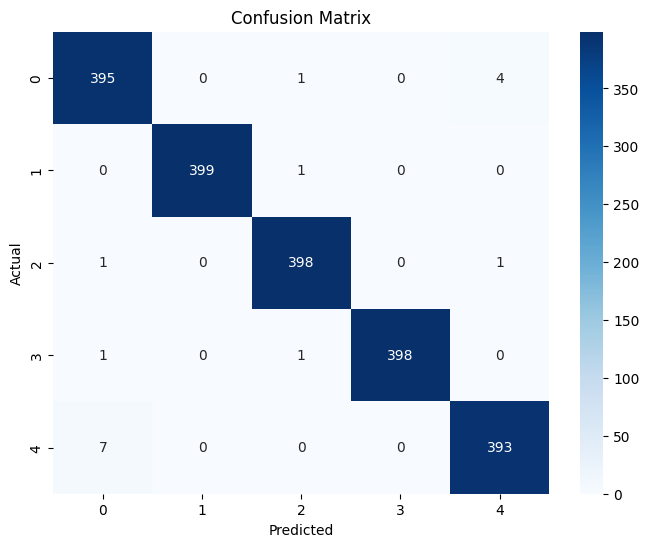

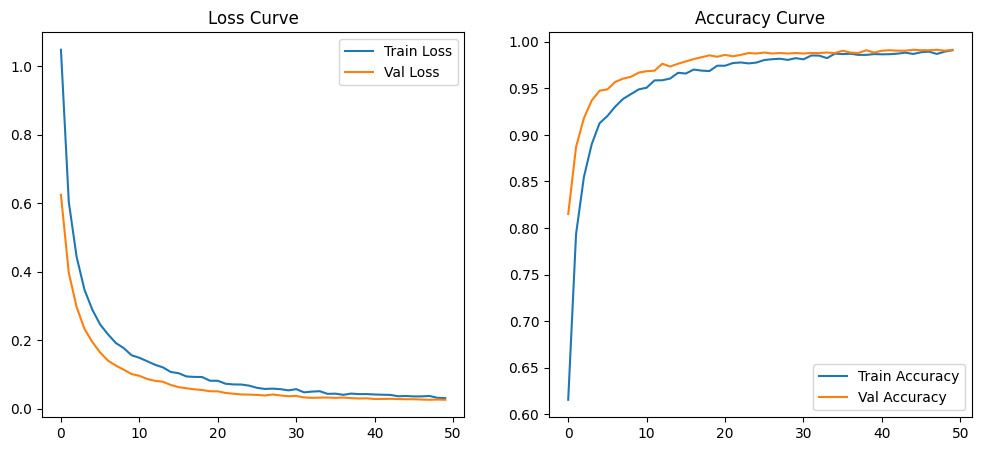

In [10]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [11]:
import tensorflow as tf

model = tf.keras.models.load_model("C:\\stphen hawking\\Gesture\\model\\hand_gesture_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("C:\\stphen hawking\\Gesture\\model\\hand_gesture_model.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpylz3f8n9\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmpylz3f8n9\assets
